## Overturning 

This notebook for the following taks.
1. Compare overturning in sigma vs z space.
2. Compare overturning computed just integrating along `i` index on native grid vs using ecco algorithm (uses both zonal and meridional transport).
3. Look at spatial pattern of transport in density layers and depth of density layers. 

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, levels=9, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
        
    p = da.plot.contourf(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, levels = levels, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False, extend='both')
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    
    ax.add_feature(cfeature.LAND) #, zorder=100, edgecolor='k') #, facecolor='black')
    #ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    
    return fig, cb 

In [7]:
ppdir_z = "/gws/nopw/j04/snapdragon/hkhatri/Data_Consolidated/"
ppdir_sigma =  "/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Transport_sigma/Regridded/"
ppdir_ecco = "/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Overturning_Atlantic/"

ds_z = []
ds_sigma = []
ds_ecco = []

for year in range(1960, 1963):
    
    d = xr.open_dataset(ppdir_z + str(year) +"_diaptr.nc", chunks = {'time_counter':1})
    ds_z.append(d.zomsfatl.drop(['time_counter', 'time_centered']))

    d = xr.open_dataset(ppdir_sigma + "Transport_sigma_" + str(year) + "_r1.nc", chunks = {'time':1})
    ds_sigma.append(d.drop('time'))
    
    d = xr.open_dataset(ppdir_ecco + "Overturning_" + str(year) + "_r1.nc", chunks = {'time':1})
    ds_ecco.append(d.drop('time'))
    
#    ds1 = []
#    ds2 = []
#    for r in range(1,2):
        
#        d = xr.open_dataset(ppdir_sigma + "Transport_sigma_" + str(year) + "_r" + str(r) + ".nc", chunks = {'time':1})
#        ds1.append(d.drop('time'))
        
#        d = xr.open_dataset(ppdir_ecco + "Overturning_" + str(year) + "_r" + str(r) + ".nc", chunks = {'time':1})
#        ds2.append(d.drop('time'))
        
#    ds1 = xr.concat(ds1, dim='r')
#    ds_sigma.append(ds1)
        
ds_z = xr.concat(ds_z, dim='year')
ds_z = ds_z.rename({'time_counter':'time'})
ds_z = ds_z.isel(r=0)

ds_sigma = xr.concat(ds_sigma, dim='year')
ds_ecco = xr.concat(ds_ecco, dim='year')

In [8]:
print(ds_z, ds_sigma, ds_ecco)

<xarray.DataArray 'zomsfatl' (year: 3, time: 125, depthw: 75, y: 451, x: 1)>
dask.array<getitem, shape=(3, 125, 75, 451, 1), dtype=float32, chunksize=(1, 1, 75, 451, 1), chunktype=numpy.ndarray>
Coordinates:
  * depthw   (depthw) float32 0.0 1.024 2.103 ... 5.393e+03 5.596e+03 5.8e+03
    nav_lat  (y, x) float32 3.997 4.246 4.495 4.745 ... 79.78 79.85 79.92 79.99
    nav_lon  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: year, time, y, x
Attributes:
    standard_name:       meridional_streamfunction_atlantic
    long_name:           Meridional Stream-Function: Atlantic
    units:               Sv
    online_operation:    average
    interval_operation:  900 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 900 s) <xarray.Dataset>
Dimensions:            (year: 3, time: 125, sigma0: 48, lat: 134, lon: 200,
                        sigma0_bnds: 49, j_c: 450)
Coordinates:
  * sigma0             (sigma0) flo

In [9]:
%time tmp_z = ds_z.isel(year=0).mean(['time']).assign_coords(y=ds_z.nav_lat.isel(x=0)).compute()

%time tmp_sigma = ds_sigma['psi_sigma'].isel(year=0).mean(['time']).compute()

%time tmp_ecco = ds_ecco.isel(year=0).mean(['time']).compute()

CPU times: user 468 ms, sys: 189 ms, total: 657 ms
Wall time: 1.29 s
CPU times: user 223 ms, sys: 68.9 ms, total: 292 ms
Wall time: 560 ms
CPU times: user 395 ms, sys: 113 ms, total: 508 ms
Wall time: 408 ms


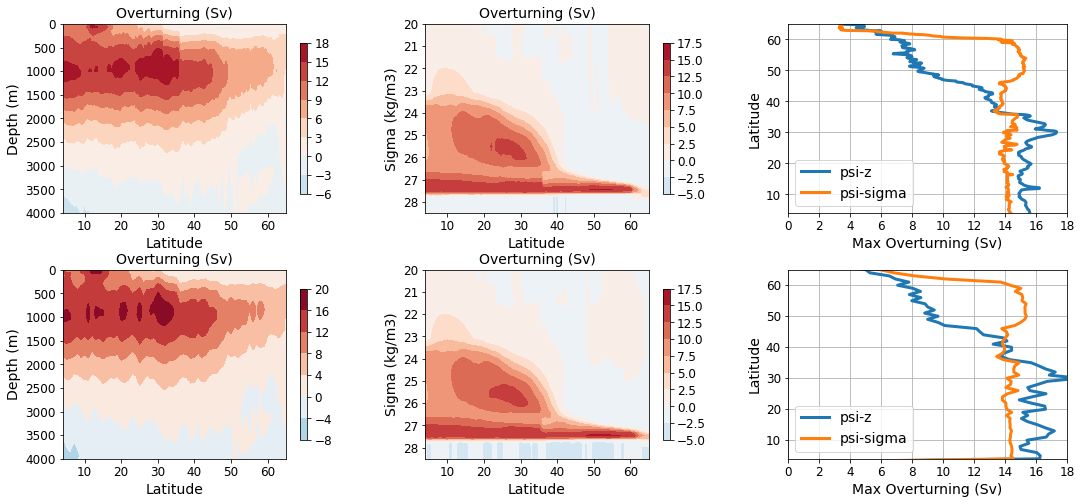

In [11]:
grid1 = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,8])

ax = fig.add_subplot(grid1[0, 0])

#tmp = ds_z.isel(year=0, r=0).mean('time').assign_coords(y=ds_z.nav_lat.isel(x=0)).compute()

#p = tmp_z.plot(ax=ax, x='nav_lat', y='depthw', vmin=-20, vmax=20, levels=39,
#                 cmap='RdBu_r', add_labels=False)
p = ax.contourf(tmp_z.nav_lat, tmp_z.depthw, tmp_z.isel(x=0), vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 1])
p = ax.contourf(tmp_sigma['j_c'], tmp_sigma.sigma0, tmp_sigma/1e6, vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([20., 28.5])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 2])
ax.plot(tmp_z.isel(x=0).max('depthw'), tmp_z.nav_lat, lw=3, label='psi-z')
ax.plot(tmp_sigma.max('sigma0')/1e6, tmp_sigma['j_c'], lw=3, label='psi-sigma')
plt.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([4., 65.])
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Max Overturning (Sv)', fontsize=14)
ax.set_xlim([0., 18.])
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

# plot with ecco algorithm (consisdered both zonal and meridional transport terms)
ax = fig.add_subplot(grid1[1, 0])
p = ax.contourf(tmp_ecco.lat, tmp_ecco.lev, tmp_ecco['Overturning_z']/ 1e6, vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[1, 1])
p = ax.contourf(tmp_ecco.lat, tmp_ecco.sigma0, tmp_ecco['Overturning_sigma']/1e6, vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([20., 28.5])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[1, 2])
ax.plot(tmp_ecco['Overturning_z'].max('lev')/1e6, tmp_ecco.lat, lw=3, label='psi-z')
ax.plot(tmp_ecco['Overturning_sigma'].max('sigma0')/1e6, tmp_ecco.lat, lw=3, label='psi-sigma')
plt.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([4., 65.])
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Max Overturning (Sv)', fontsize=14)
ax.set_xlim([0., 18.])
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

In [121]:
%time tmp_v = ds_sigma['v_transport_sigma'].isel(year=0, sigma0=34).mean(['time', 'r']).compute()
%time tmp_thick = ((ds_sigma['depth_sigma'].isel(year=0, sigma0_bnds=35) - ds_sigma['depth_sigma'].isel(year=0, sigma0_bnds=34)).mean(['time', 'r']).compute())

CPU times: user 2.47 s, sys: 3.37 s, total: 5.85 s
Wall time: 16.3 s
CPU times: user 3.02 s, sys: 3.12 s, total: 6.14 s
Wall time: 4.21 s


/tmp/ipykernel_611/3174417348.py:8: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"


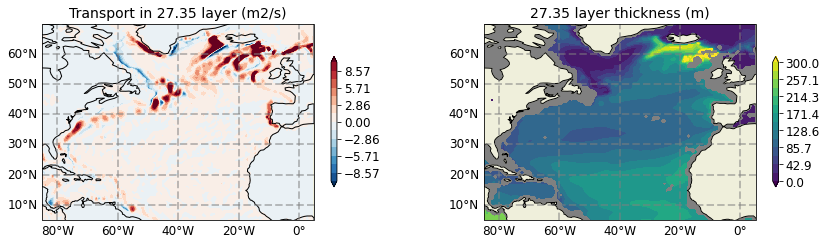

In [134]:
lat_lon_ext = [-85., 5., 5., 70.]

grid1 = plt.GridSpec(1, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[14, 4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')

[p, cb] = plot_sec(ax, tmp_v, vmin=-10., vmax=10.,  lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='lon', lat='lat', cmap='RdBu_r', title='Transport in 27.35 layer (m2/s)')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
[p, cb] = plot_sec(ax, tmp_thick, vmin=0., vmax=300., lat_lon_ext = lat_lon_ext, levels = 15,
                   lon='lon', lat='lat', cmap='viridis', title='27.35 layer thickness (m)')

#### Overturning and Heat Transport

Based on above comaprisons, it can be concluted that overturning can be computed resonably well by integrating transport along `i` index on native grid, even through grid deviates from latitude isolines at higher latitudes. So, for simplicity and efficiency, we stick with this approach.

Below, we look at overturning circulation and meridional heat transport quantities.

In [3]:
ppdir = "/gws/nopw/j04/snapdragon/hkhatri/Data_sigma/Overturning_Heat_Transport/"

ppdir_z = "/gws/nopw/j04/snapdragon/hkhatri/Data_Consolidated/"

var_list = ['hfbasin_atlantic', 'zomsfatl', 'hfovgyre_atlantic', 'hfovovrt_atlantic']

year = 1961

ds_z = xr.open_dataset(ppdir_z + str(year) +"_diaptr.nc", chunks = {'time_counter':1})
ds_z = ds_z.get(var_list)
ds_z = ds_z.drop(['time_counter', 'time_centered']).rename({'time_counter':'time'})
ds_z = ds_z.isel(r=0)

ds = xr.open_dataset(ppdir + "Overturning_Heat_Transport_" + str(year) + "_r1.nc", chunks={'time':1})

ds_mask = xr.open_dataset("/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/Mask_UV_grid.nc")

print(ds, ds_z)

<xarray.Dataset>
Dimensions:                (j_c: 450, time: 125, lev: 75, sigma0: 48)
Coordinates:
  * j_c                    (j_c) int32 699 700 701 702 ... 1145 1146 1147 1148
  * time                   (time) object 1961-11-16 00:00:00 ... 1972-03-16 0...
  * lev                    (lev) float64 0.5058 1.556 ... 5.698e+03 5.902e+03
  * sigma0                 (sigma0) float64 16.0 18.0 19.5 ... 28.9 29.5 30.5
Data variables:
    latitude               (j_c) float32 dask.array<chunksize=(450,), meta=np.ndarray>
    Overturning_z          (time, lev, j_c) float64 dask.array<chunksize=(1, 75, 450), meta=np.ndarray>
    Overturning_sigma      (time, j_c, sigma0) float64 dask.array<chunksize=(1, 450, 48), meta=np.ndarray>
    MHT_sigma              (time, j_c, sigma0) float64 dask.array<chunksize=(1, 450, 48), meta=np.ndarray>
    MHT_overturning_sigma  (time, j_c, sigma0) float64 dask.array<chunksize=(1, 450, 48), meta=np.ndarray>
    MHT_z                  (time, lev, j_c) float64 dask

Text(0.5, 1.0, 'Overturning Heat Transport')

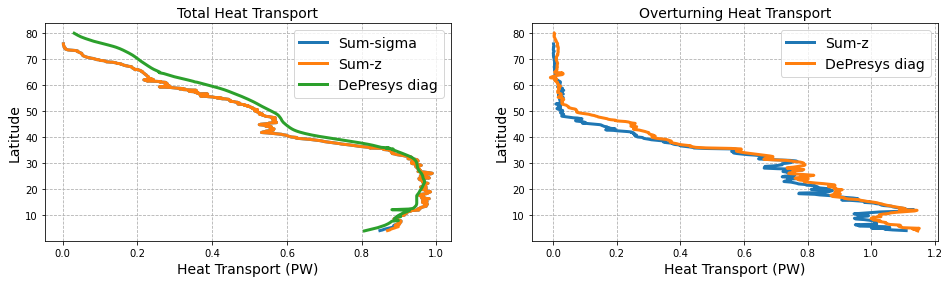

In [4]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
plt.plot(ds.MHT_sigma.sum('sigma0').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds_z.hfbasin_atlantic.mean(['time','x']),  ds_z.nav_lat.mean('x'), lw=3)
plt.grid(ls='--')
plt.legend(['Sum-sigma', 'Sum-z', 'DePresys diag'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Total Heat Transport', fontsize=14)

plt.subplot(1,2,2)
plt.plot(ds.MHT_overturning_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds_z.hfovovrt_atlantic.mean(['time','x']),  ds_z.nav_lat.mean('x'), lw=3)
plt.grid(ls='--')
plt.legend(['Sum-z', 'DePresys diag'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Overturning Heat Transport', fontsize=14)

(-0.2, 1.2)

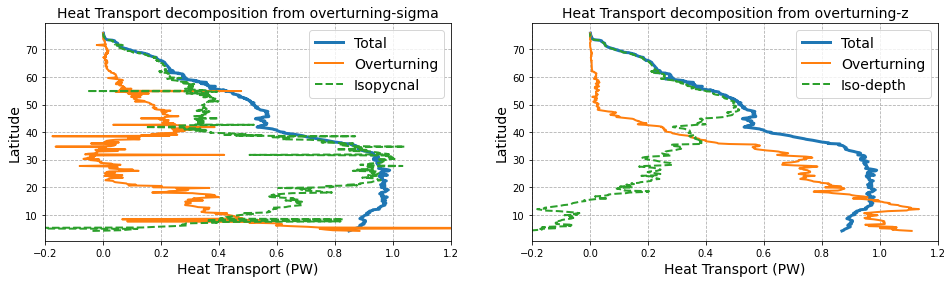

In [5]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
plt.plot(ds.MHT_sigma.isel(sigma0=slice(0,48)).sum('sigma0').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_sigma.sum('sigma0').mean('time')/1e15,  ds.latitude, lw=2)
plt.plot((ds.MHT_sigma - ds.MHT_overturning_sigma).sum('sigma0').mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Isopycnal'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-sigma', fontsize=14)
plt.xlim([-0.2, 1.2])

plt.subplot(1,2,2)
plt.plot(ds.MHT_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=2)
plt.plot((ds.MHT_z - ds.MHT_overturning_z).sum('lev').mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Iso-depth'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-z', fontsize=14)
plt.xlim([-0.2, 1.2])

(-0.2, 1.2)

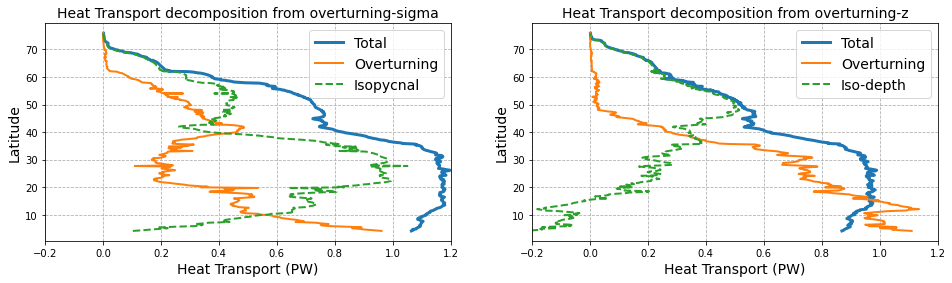

In [6]:
# To get read of noise, just consider layers sigma <= 27.6

fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
plt.plot(ds.MHT_sigma.isel(sigma0=slice(0,37)).sum('sigma0').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_sigma.isel(sigma0=slice(0,37)).sum('sigma0').mean('time')/1e15,  
         ds.latitude, lw=2)
plt.plot((ds.MHT_sigma - ds.MHT_overturning_sigma).isel(sigma0=slice(0,37)).sum('sigma0').mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Isopycnal'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-sigma', fontsize=14)
plt.xlim([-0.2, 1.2])

plt.subplot(1,2,2)
plt.plot(ds.MHT_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=2)
plt.plot((ds.MHT_z - ds.MHT_overturning_z).sum('lev').mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Iso-depth'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-z', fontsize=14)
plt.xlim([-0.2, 1.2])

(-0.2, 1.2)

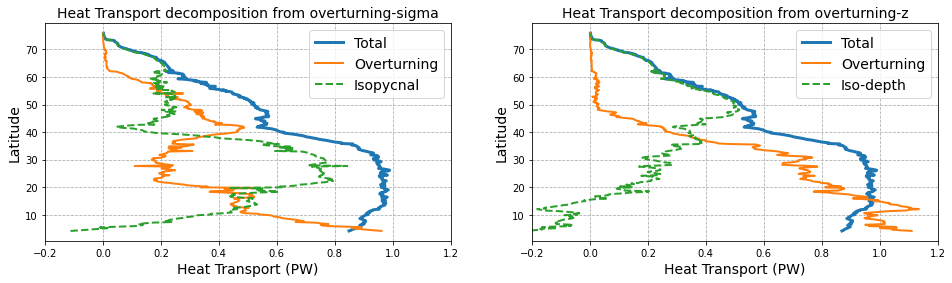

In [9]:
# To get read of noise, just consider layers sigma <= 27.6 for overturning
# Otherwise, consider full

fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
plt.plot(ds.MHT_sigma.isel(sigma0=slice(0,48)).sum('sigma0').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_sigma.isel(sigma0=slice(0,37)).sum('sigma0').mean('time')/1e15,  
         ds.latitude, lw=2)
plt.plot((ds.MHT_sigma.sum('sigma0') - ds.MHT_overturning_sigma.isel(sigma0=slice(0,37)).sum('sigma0')).mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Isopycnal'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-sigma', fontsize=14)
plt.xlim([-0.2, 1.2])

plt.subplot(1,2,2)
plt.plot(ds.MHT_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=3)
plt.plot(ds.MHT_overturning_z.sum('lev').mean('time')/1e15,  ds.latitude, lw=2)
plt.plot((ds.MHT_z - ds.MHT_overturning_z).sum('lev').mean('time')/1e15,  
         ds.latitude, lw=2, ls='--')
plt.grid(ls='--')
plt.legend(['Total', 'Overturning', 'Iso-depth'], fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Heat Transport (PW)', fontsize=14)
plt.title('Heat Transport decomposition from overturning-z', fontsize=14)
plt.xlim([-0.2, 1.2])

In [33]:
%time tmp_z = ds['Overturning_z'].mean(['time']).assign_coords(j_c=ds.latitude).compute()

%time tmp_sigma = ds['Overturning_sigma'].mean(['time']).assign_coords(j_c=ds.latitude).compute()

CPU times: user 265 ms, sys: 71.9 ms, total: 337 ms
Wall time: 480 ms
CPU times: user 169 ms, sys: 45.1 ms, total: 214 ms
Wall time: 146 ms


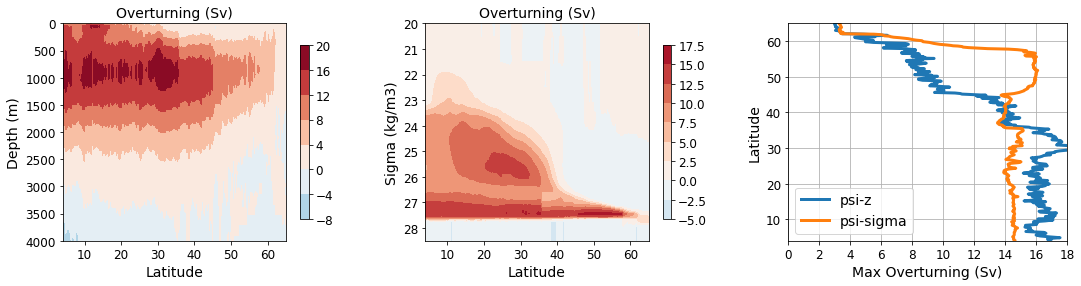

In [38]:
grid1 = plt.GridSpec(1, 3, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid1[0, 0])
p = ax.contourf(ds.latitude, ds.lev, 
                tmp_z/ 1e6, vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 1])
p = ax.contourf(ds.latitude, ds.sigma0, tmp_sigma.transpose()/1e6, 
                vmin=-20., vmax=20., cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([20., 28.5])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 2])
ax.plot(tmp_z.max('lev')/1e6, ds.latitude, lw=3, label='psi-z')
ax.plot(tmp_sigma.max('sigma0')/1e6, ds.latitude, lw=3, label='psi-sigma')
plt.legend(fontsize=14)
ax.grid('on')
ax.set_ylim([4., 65.])
ax.set_ylabel('Latitude', fontsize=14)
ax.set_xlabel('Max Overturning (Sv)', fontsize=14)
ax.set_xlim([0., 18.])
plt.yticks(fontsize = 12);
plt.xticks(fontsize = 12);

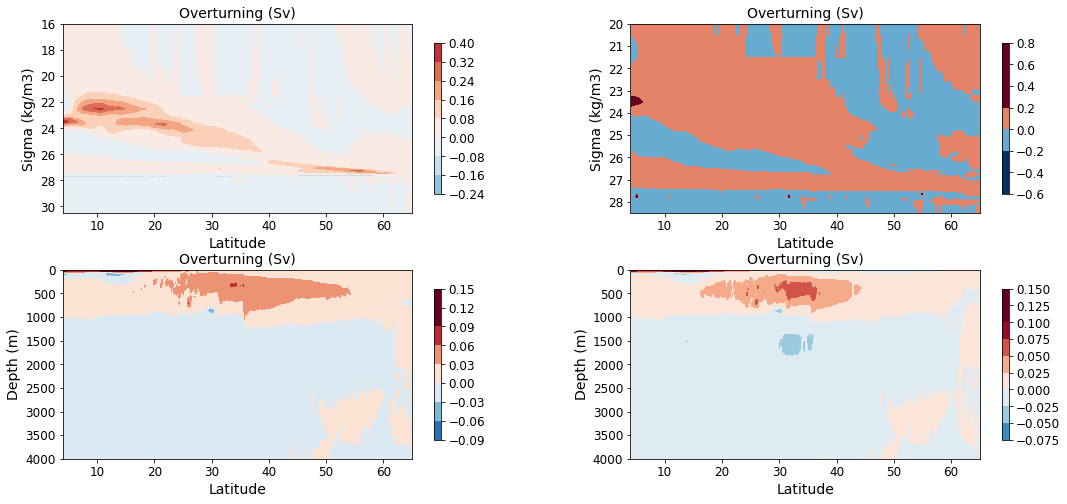

In [54]:
MHT = ds['MHT_sigma'].mean(['time']).assign_coords(j_c=ds.latitude).compute()

MHT_psi = ds['MHT_overturning_sigma'].mean(['time']).assign_coords(j_c=ds.latitude).compute()

grid1 = plt.GridSpec(2, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[18,8])

ax = fig.add_subplot(grid1[0, 0])
p = ax.contourf(ds.latitude, ds.sigma0, 
                MHT.transpose()/ 1e15, vmin=-.5, vmax=.5, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
#ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[0, 1])
p = ax.contourf(ds.latitude, ds.sigma0, MHT_psi.transpose()/1e15, 
                vmin=-.2, vmax=.2, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Sigma (kg/m3)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([20., 28.5])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

MHT = ds['MHT_z'].mean(['time']).assign_coords(j_c=ds.latitude).compute()
MHT_psi = ds['MHT_overturning_z'].mean(['time']).assign_coords(j_c=ds.latitude).compute()

ax = fig.add_subplot(grid1[1, 0])
p = ax.contourf(ds.latitude, ds.lev, 
                MHT/ 1e15, vmin=-.1, vmax=.1, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_ylim([0., 4000.])
ax.set_xlim([4., 65.])
plt.gca().invert_yaxis()

ax = fig.add_subplot(grid1[1, 1])
p = ax.contourf(ds.latitude, ds.lev, MHT_psi/1e15, 
                vmin=-.1, vmax=.1, cmap='RdBu_r')
cb = plt.colorbar(p, ax=ax, shrink=0.8) # orientation="horizontal"
cb.ax.tick_params(labelsize=12)
ax.set_ylabel('Depth (m)', fontsize=14)
ax.set_xlabel('Latitude', fontsize=14)
plt.title('Overturning (Sv)', fontsize=14)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_xlim([4., 65.])
ax.set_ylim([0., 4000.])
plt.gca().invert_yaxis()

In [72]:
ds.sigma0.values[37]

27.650000000000023

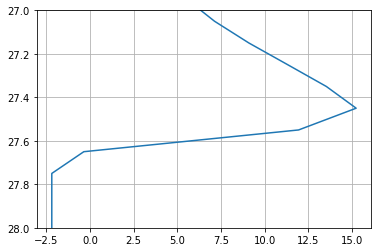

In [68]:
plt.plot(ds['Overturning_sigma'].isel(j_c=200).mean('time')/1e6, ds.sigma0)
plt.ylim([27., 28.])
plt.gca().invert_yaxis()
plt.grid()


In [63]:
ds.latitude.isel(j_c=200).values

array(46.235687, dtype=float32)